# ISEL - CSM
## Semestre 22/23
# <br>
###  <center> 3º Trabalho Prático </center>
# </br>

Trabalho realizado por:
* Guilherme Prazeres, numero <b> 49777 </b>
* Tiago Figueiredo, numero <b> 49154 </b>
* Tomás Charrua, numero <b> 49709 </b>

<hr style="border:1px color:black"> </hr>

<center><h3>Introdução</h3></center>
O objetivo deste trabalho é implementar e analisar o desempenho dum codificador/descodificador JPEG sequencial
para compressão de imagens a tons de cinzento.

Neste trabalho foram abordados algoritmos de compressão e descompressão, como a `Transformada Discreta de Cosseno (DCT)` e a `codificação Huffman`, para reduzir a quantidade de dados necessários para representar uma imagem. A codificação DC e AC são partes importantes deste processo.

`Codificação DC:` A codificação DC é responsável por representar a diferença entre os valores DC consecutivos de cada bloco. O valor DC representa a componente de baixa frequência de um bloco de 8x8 e é usado como base para codificar os valores AC. A diferença entre os valores DC consecutivos é calculada e codificada usando uma tabela de tamanho variável, como a tabela Huffman.

`Codificação AC:` A codificação AC lida com os valores AC de um bloco, que representam as componentes de alta frequência. Os valores AC são organizados em uma sequência de pares (zero_length, size), onde zero_length representa a quantidade de zeros consecutivos antes do valor AC e size indica o tamanho do valor AC. Esses pares são codificados usando uma tabela de tamanho variável, como a tabela Huffman.

Ao combinar a codificação DC e AC para todos os blocos de uma imagem, é possível criar uma sequência compacta que representa a imagem codificada no formato JPEG. Essa sequência pode ser posteriormente usada para descodificar e reconstruir a imagem original.

No processo de codificação, os valores DC são representados pela diferença entre o valor DC atual e o valor DC anterior no bloco. Essa diferença é codificada usando uma tabela de Huffman, que atribui um código binário curto aos valores DC mais frequentes e códigos mais longos aos valores menos frequentes. Os valores AC, que representam os coeficientes de alta frequência na transformada de coseno discreta (DCT), são codificados usando uma combinação de codificação de zeros consecutivos (zero run-length encoding) e codificação de tamanho/amplitude (size/amplitude coding). Isso permite uma representação eficiente dos coeficientes AC, considerando que muitos deles são zero ou têm valores baixos.

No processo de descodificação, a sequência codificada é lida e os valores DC e AC são extraídos usando as tabelas inversas. Os valores DC são reconstruídos somando a diferença ao valor DC anterior. Os valores AC são reconstruídos considerando os zeros consecutivos e os tamanhos/amplitudes codificados. Os blocos descodificados são organizados de volta à forma original da imagem e a imagem reconstruída é obtida.

É importante destacar que a codificação e a descodificação JPEG são processos perda-de-dados, o que significa que a imagem reconstruída não será idêntica à imagem original. No entanto, a compressão JPEG é projetada para minimizar a perda de qualidade perceptível, permitindo uma redução significativa no tamanho do ficheiro em comparação com a imagem não comprimida.


As tabelas que foram utilizadas na realização do trabalho, foram fornecidas pelo professor.
<hr style="border:1px color:black"> </hr>

In [1612]:
# Importar Bibliotecas
%pip install import_ipynb
import import_ipynb
import Tabelas_jpeg as tabelas 
import numpy as np
from time import time
import matplotlib.pyplot as plt
import sys
import os
from os import path
import cv2 as cv
import re
from time import time


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1613]:
imagem = cv.imread("LenaGray.tif")
imagem = cv.cvtColor(imagem, cv.COLOR_BGR2GRAY)

In [1614]:
imagem

array([[162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       [162, 162, 162, ..., 170, 155, 128],
       ...,
       [ 43,  43,  50, ..., 104, 100,  98],
       [ 44,  44,  55, ..., 104, 105, 108],
       [ 44,  44,  55, ..., 104, 105, 108]], dtype=uint8)

In [1615]:
imagem.shape

(512, 512)

<h1>Exercicio 1 </h1>
Construa uma função (codificador) que para cada bloco de 8×8 da imagem original efetue a DCT bidimensional
e construa outra função (descodificador) que faça a DCT inversa. Ver funções: cv2.dct() e cv2.idct())
Visualize a imagem depois da DCT e verifique que a DCT inversa resulta na imagem original.

In [1616]:
def acertar_tamanho_imagem(imagem):

    nlinhas = imagem.shape[0]
    ncolunas = imagem.shape[1]


    nlinhas_extra = 0 #número de linhas a adicionar para tornar a dimenão da imagem divisível por 8
    ncolunas_extra = 0 #número de colunas a adicionar para tornar a dimenão da imagem divisível por 8

    if np.remainder(nlinhas, 8) > 0:
        nlinhas_extra = 8 *(nlinhas % 8)
    if np.remainder(ncolunas, 8) > 0:
        ncolunas_extra = 8 *(ncolunas % 8)

    #nova imagem com as dimensões atualizadas
    nova_imagem = np.zeros((nlinhas + nlinhas_extra, ncolunas + ncolunas_extra))

    #coloca-se o valor da imagem original nas dimensões respetivas
    nova_imagem[:nlinhas, :ncolunas] = imagem

    ultima_col = imagem[:, 1]
    for i in range(ncolunas_extra):
        nova_imagem[:, ncolunas + i] = ultima_col

    ultima_linha = nova_imagem[-1, :]
    for j in range(nlinhas_extra):
        nova_imagem[nlinhas + j, :] = ultima_linha

    return nova_imagem, nlinhas_extra, ncolunas_extra


In [1617]:
def revert_imagem(imagem, nlinhas_extra, ncolunas_extra):
    
    nlinhas = imagem.shape[0] - nlinhas_extra
    ncolunas = imagem.shape[1] - ncolunas_extra

    imagem_original = imagem[:nlinhas, :ncolunas]

    return imagem_original

In [1618]:
resized_image, nlinhas_extra, ncolunas_extra = acertar_tamanho_imagem(imagem)
print(resized_image)
print("Nº de linhas adicionadas:", nlinhas_extra)
print("Nº de colunas adicionadas:", ncolunas_extra)

[[162. 162. 162. ... 170. 155. 128.]
 [162. 162. 162. ... 170. 155. 128.]
 [162. 162. 162. ... 170. 155. 128.]
 ...
 [ 43.  43.  50. ... 104. 100.  98.]
 [ 44.  44.  55. ... 104. 105. 108.]
 [ 44.  44.  55. ... 104. 105. 108.]]
Nº de linhas adicionadas: 0
Nº de colunas adicionadas: 0


In [1619]:
def divide_imagem_8x8(imagem):
    nlinhas, ncolunas = imagem.shape

    num_blocos_linhas = nlinhas // 8
    num_blocos_colunas = ncolunas // 8

    imagem_dividida = np.zeros((num_blocos_linhas * num_blocos_colunas, 8, 8))

    for i in range(num_blocos_linhas):
        for j in range(num_blocos_colunas):
            bloco = imagem[i*8:(i+1)*8, j*8:(j+1)*8]
            imagem_dividida[i*num_blocos_colunas + j] = bloco.astype(np.float32)

    return imagem_dividida
    

In [1620]:
def reconstruir_imagem1(imagem_8x8, nLinhas, nColunas):
    imagem = np.zeros((nLinhas, nColunas))
    
    numBlocosLinhas = int((nLinhas)/8)
    numBlocosColunas = int((nColunas)/8)
    
    cont = 0
    for i in range(numBlocosLinhas):
        for k in range(8):
            imagem[cont] = imagem_8x8[(i*numBlocosColunas):(i*numBlocosColunas) + numBlocosColunas, k].flatten()
            cont += 1
    
    return imagem



In [1621]:
def reconstruir_imagem(imagem_8x8, nLinhas, nColunas):
    numBlocosLinhas = nLinhas // 8
    numBlocosColunas = nColunas // 8
    imagem = np.zeros((nLinhas, nColunas))
    cont = 0
    for i in range(numBlocosLinhas):
        for j in range(numBlocosColunas):
            for k in range(8):
                for l in range(8):
                    imagem[i * 8 + k, j * 8 + l] = imagem_8x8[cont, k, l]
            cont += 1
    return imagem


In [1622]:
imagem_dividida = divide_imagem_8x8(imagem)
print(imagem_dividida)
#print(imagem_dividida.shape)
imagem_reconstruida = reconstruir_imagem(imagem_dividida, imagem.shape[0], imagem.shape[1])
imagem_reconstruida
#imagem_reconstruida.shape

[[[162. 162. 162. ... 157. 163. 161.]
  [162. 162. 162. ... 157. 163. 161.]
  [162. 162. 162. ... 157. 163. 161.]
  ...
  [164. 164. 158. ... 159. 159. 160.]
  [160. 160. 163. ... 162. 159. 156.]
  [159. 159. 155. ... 159. 156. 157.]]

 [[165. 161. 162. ... 163. 160. 155.]
  [165. 161. 162. ... 163. 160. 155.]
  [165. 161. 162. ... 163. 160. 155.]
  ...
  [160. 160. 155. ... 154. 156. 154.]
  [159. 162. 156. ... 155. 156. 152.]
  [159. 161. 161. ... 153. 153. 151.]]

 [[157. 156. 161. ... 156. 154. 157.]
  [157. 156. 161. ... 156. 154. 157.]
  [157. 156. 161. ... 156. 154. 157.]
  ...
  [156. 156. 153. ... 153. 153. 150.]
  [153. 160. 154. ... 150. 155. 152.]
  [155. 154. 156. ... 153. 152. 152.]]

 ...

 [[ 84.  82.  75. ...  62.  52.  56.]
  [ 81.  82.  64. ...  52.  50.  47.]
  [ 74.  70.  64. ...  55.  44.  44.]
  ...
  [ 58.  53.  50. ...  45.  49.  45.]
  [ 58.  57.  51. ...  41.  42.  50.]
  [ 58.  57.  51. ...  41.  42.  50.]]

 [[ 52.  49.  52. ...  57.  59.  75.]
  [ 44.  47.

array([[162., 162., 162., ..., 170., 155., 128.],
       [162., 162., 162., ..., 170., 155., 128.],
       [162., 162., 162., ..., 170., 155., 128.],
       ...,
       [ 43.,  43.,  50., ..., 104., 100.,  98.],
       [ 44.,  44.,  55., ..., 104., 105., 108.],
       [ 44.,  44.,  55., ..., 104., 105., 108.]])

In [1623]:
def dct_bloco(bloco):
    b = np.array(bloco)
    b = b - 128
    b = b.astype(np.float32)
    return np.round(cv.dct(b), 2)

In [1624]:
def dct_blocos(blocos):
    num_blocos = len(blocos)
    b = np.zeros_like(blocos)
    for i in range(num_blocos):
        b[i] = dct_bloco(blocos[i])
    return b

In [1625]:
def reverter_DCT(blocos):
    num_blocos = len(blocos)
    blocos_destransformados = np.array(blocos)
    for i in range(num_blocos):
        b_trans = np.round(cv.idct(blocos[i].astype(np.float32)), 2) + 128
        blocos_destransformados[i] = b_trans
# for i in range(imagem_dividida.shape[0]):
#     for j in range(imagem_dividida.shape[1]):
#         print(imagem_dividida[i, j])
   
    return blocos_destransformados

In [1626]:
#Testes

print(imagem_dividida.shape)
imagem_dct = dct_blocos(imagem_dividida)

T_imagem_idct = reverter_DCT(imagem_dct)
# for i in range(T_imagem_idct.shape[0]):
#     print(T_imagem_idct[i])
    # for j in range(T_imagem_idct.shape[1]):
    #     print(T_imagem_idct[i, j])
T_imagem = reconstruir_imagem(np.uint8(T_imagem_idct), imagem.shape[0], imagem.shape[1]).astype('uint8')
#T_imagem


(4096, 8, 8)


Text(0.5, 1.0, 'Imagem Depois da DCT inversa')

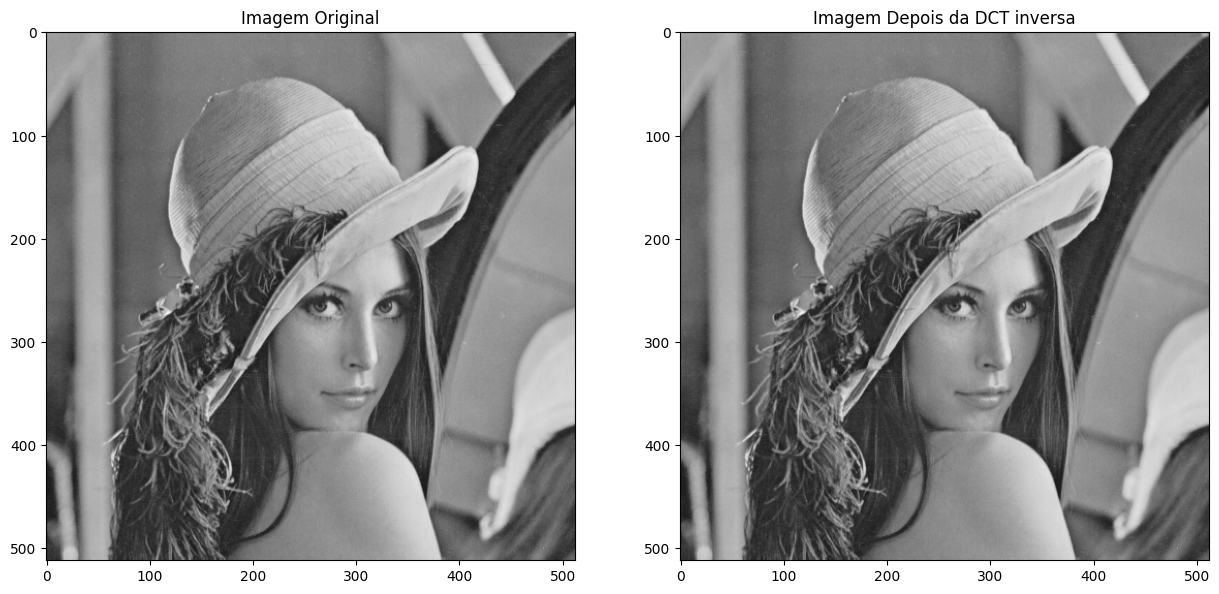

In [1627]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15))
ax1.imshow(cv.cvtColor(imagem, cv.COLOR_BGR2RGB))
ax1.set_title("Imagem Original")
ax2.imshow(cv.cvtColor(T_imagem, cv.COLOR_BGR2RGB))
ax2.set_title("Imagem Depois da DCT inversa")


# Exercício 2
Construa uma função (codificador) que para cada bloco de 8 × 8 de coeficientes da transformação efectuada faça
a divisão pela matriz de quantificação (tabela K1 no anexo da norma) multiplicada por um factor de qualidade q
(ver função quality_factor do ficheiro Tabelas_jpeg.ipynb). Veja a imagem com o conjunto dos blocos após
a quantificação. Construa uma função (descodificador) que realize a operação inversa da quantificação.
Junte estas funções às já realizadas e verifique para diferentes fatores de qualidade qual a SNR e veja a imagem
descodificada.

A função `codificador_quantize` realiza a quantização dos valores dos blocos de uma imagem. Para cada bloco, o valor é dividido pelo produto entre a tabela de quantização padrão e o fator de qualidade. Em seguida, o resultado é arredondado para o valor mais próximo. Essa operação é realizada para todos os blocos, e o resultado é retornado como uma lista de blocos quantizados.
 
Essa etapa de quantização é aplicada em processos de compressão de imagens para reduzir a quantidade de informação necessária para representar a imagem, permitindo eficiencia no espaço de armazenamento.


In [1628]:
def codificador_quantize(blocos, q):
    fator = tabelas.quality_factor(q)
    quantizados = []
    for bloco in blocos:
        bloco_quantizado = np.round(bloco / (tabelas.Q * fator))
        quantizados.append(bloco_quantizado)
    return quantizados

In [1629]:
blocos_dct = dct_blocos(imagem_dividida)
qualidade = 50
blocos_quantificados = codificador_quantize(blocos_dct, qualidade)
print(blocos_quantificados)
#blocos_quantificados.shape

[array([[16.,  0.,  0., -0.,  0., -0., -0.,  0.],
       [ 1., -0.,  0., -0.,  0.,  0., -0.,  0.],
       [-0., -0., -0.,  0., -0., -0.,  0., -0.],
       [ 0.,  0.,  0.,  0., -0., -0.,  0.,  0.],
       [-0., -0., -0., -0.,  0.,  0., -0., -0.],
       [ 0.,  0., -0., -0., -0.,  0.,  0.,  0.],
       [-0.,  0.,  0.,  0.,  0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.,  0.,  0.,  0.]]), array([[15.,  2.,  0.,  0., -0.,  0.,  0., -0.],
       [ 1., -0.,  0.,  0., -0.,  0.,  0.,  0.],
       [-0.,  0., -0., -0.,  0., -0., -0.,  0.],
       [-0., -0.,  0.,  0.,  0.,  0., -0., -0.],
       [ 0.,  0.,  0.,  0., -0.,  0.,  0.,  0.],
       [-0., -0., -0.,  0.,  0., -0., -0., -0.],
       [-0.,  0.,  0., -0.,  0., -0., -0.,  0.],
       [ 0., -0., -0.,  0., -0.,  0.,  0., -0.]]), array([[14.,  1., -0., -1.,  0.,  0.,  0., -0.],
       [ 1., -0., -0., -0.,  0.,  0.,  0., -0.],
       [-0., -0.,  0.,  0., -0., -0., -0.,  0.],
       [-0.,  0.,  0.,  0., -0.,  0., -0., -0.],
       [ 0., -0

A função `descodificador_quantize` realiza a operação inversa da quantização. Para cada bloco quantizado, o valor é multiplicado pelo produto entre a tabela de quantização padrão e o fator de qualidade. O resultado é retornado como uma lista de blocos descodificados. Essa etapa de descodificação é necessária para reverter a quantização aplicada anteriormente, de modo a obter os valores originais dos blocos de imagem. 

Isso é especialmente importante em processos de descompressão de imagens, onde a informação quantizada precisa ser recuperada para reconstruir a imagem original com maior fidelidade possível.

In [1630]:
def descodificador_quantize(blocos, q):
    fator = tabelas.quality_factor(q)
    descodificados = []
    for bloco in blocos:
        bloco_descodificado = np.multiply(bloco, tabelas.Q * fator)
        descodificados.append(bloco_descodificado)
    return descodificados


In [1631]:
blocos_desquantificados = descodificador_quantize(blocos_quantificados, qualidade)
print(blocos_desquantificados)

[array([[256.,   0.,   0.,  -0.,   0.,  -0.,  -0.,   0.],
       [ 12.,  -0.,   0.,  -0.,   0.,   0.,  -0.,   0.],
       [ -0.,  -0.,  -0.,   0.,  -0.,  -0.,   0.,  -0.],
       [  0.,   0.,   0.,   0.,  -0.,  -0.,   0.,   0.],
       [ -0.,  -0.,  -0.,  -0.,   0.,   0.,  -0.,  -0.],
       [  0.,   0.,  -0.,  -0.,  -0.,   0.,   0.,   0.],
       [ -0.,   0.,   0.,   0.,   0.,  -0.,  -0.,  -0.],
       [  0.,  -0.,  -0.,  -0.,  -0.,   0.,   0.,   0.]]), array([[240.,  22.,   0.,   0.,  -0.,   0.,   0.,  -0.],
       [ 12.,  -0.,   0.,   0.,  -0.,   0.,   0.,   0.],
       [ -0.,   0.,  -0.,  -0.,   0.,  -0.,  -0.,   0.],
       [ -0.,  -0.,   0.,   0.,   0.,   0.,  -0.,  -0.],
       [  0.,   0.,   0.,   0.,  -0.,   0.,   0.,   0.],
       [ -0.,  -0.,  -0.,   0.,   0.,  -0.,  -0.,  -0.],
       [ -0.,   0.,   0.,  -0.,   0.,  -0.,  -0.,   0.],
       [  0.,  -0.,  -0.,   0.,  -0.,   0.,   0.,  -0.]]), array([[224.,  11.,  -0., -16.,   0.,   0.,   0.,  -0.],
       [ 12.,  -0.,  -0., 

# Exercício 3
Construa uma função (codificador) que faça a codificação diferencial dos coeficientes DC após a quantificação.
Construa a função inversa para o descodificador


A função `codificador_DC` é responsável por codificar o valor DC (Differential DC) de cada bloco quantificado. Esta itera sobre os blocos quantificados e calcula a diferença entre o valor DC atual e o DC anterior. A diferença é limitada a um intervalo específico e convertida para a sua representação binária. Em seguida, o código DC é formado concatenando o tamanho da representação binária e a mesma. 

O resultado é armazenado em uma lista de códigos DC codificados. A função retorna essa lista como resultado.

In [1632]:
def codificador_DC(blocos_quant):
    DCcodific  = []
    DCanterior = 0
    
    for b in blocos_quant:
        # Calculo da diferença entre o DC atual e o DC anterior
        DCDiff = int(b[0][0] - DCanterior)
        DCDiff =  np.clip(DCDiff, -((2**11)-1), (2**11) - 1)
        
        # Obtém o valor da representação binária (Codificação)
        if DCDiff == 0: DCDiff = ""                          
        elif DCDiff > 0: DCDiff = format(DCDiff, 'b')            
        else:                                  
            DCDiff = format(np.abs(DCDiff), 'b')  
            DCDiff = ''.join([b.replace('1','a').replace('0','1').replace('a','0') for b in DCDiff])

        # Passo 3:: Obter o valor de K3(x)
        tamanho    = str(tabelas.K3[len(DCDiff)])
        DCcodific.append(str(tamanho + DCDiff))
        DCanterior = b[0][0]

    return DCcodific

A função `descodificador_DC` tem como objetivo decodificar um código DC codificado para obter o valor DC original. Primeiro, verifica se o código DC é igual ao código correspondente a DC igual a zero. Se for o caso, retorna um bloco 8x8 preenchido com o valor DC anterior. Caso contrário, decodifica o tamanho do código DC, procurando-o na tabela de tamanhos pré-definidos.

 Em seguida, decodifica o valor DC propriamente dito a partir do restante do código DC. Se o código DC começar com "1", significa que o valor DC é negativo, então é realizado o complemento de um para obter o valor correto. Caso contrário, o código DC é interpretado como um valor DC positivo. 

O valor DC original é calculado somando-se o valor DC decodificado com o valor DC anterior. Por fim, um novo bloco 8x8 é criado, preenchido com o valor DC original, e é retornado como resultado.

In [1633]:
def descodificador_DC(cod_dc, dc_anterior):
    # Caso o DC seja 0
    if cod_dc == tabelas.K3[0]:  
        return [[dc_anterior] * 8] * 8

    # Descodificar o tamanho
    size = None
    for key, value in tabelas.K3.items():
        if value == cod_dc[:len(value)]:
            size = key
            break
    
    if not size:
        raise ValueError("Erro! Código DC inválido...")

    # Decodificar o DC
    cod_dc = cod_dc[len(tabelas.K3[size]):]
    # Caso o DC seja negativo
    if cod_dc[0] == "1":  
        dc = int("".join(map(lambda x: "1" if x == "0" else "0", cod_dc)), 2)
        dc = -dc
    # Caso o DC seja positivo
    else: dc = int(cod_dc, 2)

    # Calculo do DC original
    dc_original = dc + dc_anterior

    # Cria um novo bloco 8x8 original com o valor DC
    bloco_original = [[dc_original] * 8 for _ in range(8)]
    
    return bloco_original

In [1634]:
lena_DC = codificador_DC(blocos_quantificados)
for i in range(0,3):
    print("\n"+str(i+1)+"ª Componente DC:            " + str(blocos_quantificados[i][0][0]))
    print(str(i+1)+"ª Componente DC codificada: " + str(lena_DC[i]))


1ª Componente DC:            16.0
1ª Componente DC codificada: 11010000

2ª Componente DC:            15.0
2ª Componente DC codificada: 0100

3ª Componente DC:            14.0
3ª Componente DC codificada: 0100


# Exercício 4
Construa uma função (codificador) que crie um array com a indexação em zig-zag dos coeficientes AC após a
quantificação e crie um array com os pares (zero run length, nonzero value).
Construa a função inversa para o descodificador.



A função auxiliar `getBinaryCodific` converte um valor numérico para binário. O comportamento da função depende do valor de entrada:

*Se o valor for igual a 0, é retornado uma string vazia, indicando um caso especial sem codificação.

*Se o valor for positivo, a representação binária é obtida diretamente utilizando a função `format(valor, 'b')`.

*Se o valor for negativo, a representação binária é obtida a partir do valor absoluto do número. Em seguida, é realizado o complemento da representação binária, invertendo os 0s e 1s. Isso é feito substituindo temporariamente 1s por um caractere especial 'a', substituindo os 0s restantes por 1s e, por fim, substituindo os 'a's por 0s.

A função retorna a representação binária correspondente ao valor de entrada. Esse tipo de função é comumente utilizada em contextos de codificação de dados, onde a conversão para representação binária é necessária.

In [1635]:
def getBinaryCodific(valor):
    if valor == 0:                         
        valor = ""                          
        
    elif valor > 0:                                                          
        valor = format(valor, 'b')          
        
    else:                                  
        valor = format(np.abs(valor), 'b')  
        valor = ''.join([b.replace('1','a').replace('0','1').replace('a','0') for b in valor])
        
    return valor

Esta função função realiza a codificação da sequência de valores AC dos blocos quantificados. Primeiro, cada bloco quantificado é percorrido individualmente num ciclo. Dentro deste são realizados os seguintes passos:
* O bloco quantificado é convertido numa matriz unidimensional usando a função reshape com o parâmetro (64) e a ordem 'F', que indica a ordem da leitura dos elementos.

* A matriz unidimensional do bloco é rearranjada usando a operação de zigzag, que segue um padrão específico para extrair os elementos de forma eficiente.

* É inicializada uma variável auxiliar com o valor zero. Essa variável será usada como um contador para a sequência de zeros consecutivos encontrados.

* Cria-se uma lista para armazenar os pares (Zero Run Length, Non Zero Value).

* Percorre-se cada valor do bloco zigzag e se o valor for igual a zero, incrementa-se o contador que quando atingir o valor 16, significa que houve uma sequência de 15 zeros consecutivos. Nesse caso, adiciona-se o par (15, 0) à lista de pares e reinicia-se o contador.

* Se for diferente de zero, quantiza-se o valor para garantir que esteja dentro do intervalo aceitável e adiciona-se o par (zeroRunLen, valorQuantizado) à lista `pares`. O contador `zeroRunLen` é reiniciado.

* Após o loop que percorre os valores do bloco zigzag, adiciona-se o par (0, 0) à lista para indicar o fim da sequência AC do bloco.

* De seguida, inicia-se um novo loop para percorrer cada par (Zero Run Length, Non Zero Value) da lista de pares. Para cada par, obtém-se o tamanho codificado do valor quantizado usando a tabela K5 e a função getBinaryCodific() para obter a representação binária do valor quantizado. O tamanho codificado é concatenado com a representação binária e o resultado é armazenado numa variável.

* Após o loop que percorre os pares, junta-se todos os elementos do codico AC do bloco numa única string, adicionada a uma lista de codigos AC.

* Por fim retorna-se a lista que contém as codificações AC de todos os blocos quantificados.

In [1636]:
def codificador_AC(blocos_quant):

    ACcodific = []
    for bloco in blocos_quant:
        # Passo 1 :: Aplicação do conceito de zigzag, com auxiliares fornecidas pelo docente
        blocoReshape = bloco.reshape((64), order='F')
        blocoZigZag  = np.array(blocoReshape[np.argsort(tabelas.ind_zz)], dtype=int)[1:]
        
        # Variáveis:
        zeroRunLen = 0         # Auxiliar de contador da Zero Run Length
        pares      = []        # Auxiliar com os pares (Zero Run Length, Non Zero Value)
        ACBloco    = []        # Array de retorno, terá a codificação, em string, da sequência AC de cada bloco
        nonZeroValues  = len(np.where(blocoZigZag != 0)[0])  # Auxiliar com o número de Non Zero Value no bloco
        nonZeroPairAux = 0     # Auxiliar de contador de non-zero-values já vistos
        
        # Passo 2 :: Obter os pares
        for valor in blocoZigZag:
            if (valor == 0): # Se o valor for 0...
                zeroRunLen = zeroRunLen + 1 # Aumenta-se o contador
                if (zeroRunLen == 16 and nonZeroPairAux != nonZeroValues): # Se já se tiver atingido 15 no contador,
                    pares.append((15, 0))                                  # e se ainda existirem mais pares (não for EOB)
                    zeroRunLen = 0                                         # adiciona-se o par (15, 0) e reinicia-se a contagem
            else:                           # De outra forma...
                valorPar = np.clip(valor, -((2**10)-1), ((2**10)-1))
                pares.append((zeroRunLen, valorPar))                   # Guarda-se o par (Zero Run Length, Non Zero Value)
                if (valor != 0):                                       # verifica-se se é diferente de zero...
                    nonZeroPairAux = nonZeroPairAux + 1
                zeroRunLen = 0                                         # ...e reinicia-se o contador

        # Passo 3 :: Adicionar sinalizador de EOB
        pares.append((0,0))   
        
        # Passo 4 :: Obter K5(Zero Run Length, Non Zero Value Size)(Non Zero Value) e concatenar em String
        ACBloco = [str(tabelas.K5[par[0], len(getBinaryCodific(par[1]))]) + str(getBinaryCodific(par[1])) for par in pares]
        ACcodific.append(''.join(ACBloco))
    return ACcodific



In [1637]:
# #Teste codificador e descodificador AC
# bloco_teste = np.zeros((8, 8))
# bloco_teste[0][0] = 80
# bloco_teste[0][1] = 1
# bloco_teste
# print(bloco_teste)

# string_rlc = codificador_AC(bloco_teste)
# print(string_rlc)

# Exercício 5
Junte estas funções às já realizadas e veja a imagem descodificada.

A função `cod_JPEG` tem como objetivo realizar a codificação do valor DC e dos valores AC dos blocos 8x8 fornecidos como entrada.

A codificação JPEG é feita em duas etapas principais: `codificação DC` e `codificação AC`.

`Codificação DC:`   
A função codificador_DC é chamada para codificar os valores DC dos blocos. A função retorna uma matriz DCCodific contendo as codificações DC.
A matriz DCCodific é redimensionada para ter a forma (n_blocos, 1, -1). Isto é feito para que os valores DC codificados sejam organizados numa matriz com uma única coluna, de acordo com a convenção do formato JPEG.

`Codificação AC:`   
A função codificador_AC é chamada para codificar os valores AC dos blocos. A função retorna uma matriz ACCodific contendo as codificações AC.
Da mesma forma que a codificação DC, a matriz ACCodific é redimensionada para ter a forma (n_blocos, 1, -1).

`Composição dos códigos DC e AC:`   
Os códigos DC e AC são concatenados para formar uma única sequência de bits, representando todos os blocos. Tal é feito com o uso da função np.concatenate com axis=1 para concatenar as matrizes DCreshape e ACreshape ao longo do eixo das colunas.
A sequência de bits resultante é convertida numa única string a partir do método flatten().

O resultado final, denominado ACDC, é a sequência de bits contendo as codificações na ordem DC AC AC ... AC EOB DC AC AC ... AC EOB ... EOB. A sequência representa a versão codificada dos blocos de 8x8 no formato JPEG.

In [1638]:
def cod_JPEG(blocos):

    # Passo 1 :: Obtenção das codificações DC e AC
    DCCodific = np.array(codificador_DC(blocos))
    ACCodific = np.array(codificador_AC(blocos))
    
    # Passo 2 :: Colocação das codificações na ordem DC AC AC ... AC EOB DC AC AC ... AC EOB ... EOB
    DCreshape = DCCodific.reshape(len(DCCodific), 1, -1)
    ACreshape = ACCodific.reshape(len(ACCodific), 1, -1) 
    ACDC = ''.join(np.concatenate((DCreshape, ACreshape), axis=1).flatten())
    return ACDC
            

In [1639]:
# bloco_test = np.zeros((8,8))
# bloco_test[0][0] = 80
# bloco_test[0][1] = 1
# bloco_test

# string_dpcm = codificador_DC(bloco_test.astype(int))
# #print(string_dpcm)

# string_rlc = codificador_AC(bloco_test)
# #print(string_rlc)

codific = cod_JPEG(blocos_quantificados)
#codific

A função `descodificador_JPEG` tem como objetivo realizar a descodificação dos dados codificados no formato JPEG. A função recebe como entrada a sequência de bits codificados (cod_JPEG) e o número de blocos a serem descodificados (n_blocos).

`Preparação de tabelas inversas:`   
Duas tabelas inversas são criadas: K3_inversa e K5_inversa. Essas tabelas mapeiam os códigos codificados de volta para os valores originais que representam. Isso é necessário para a descodificação.

`Preparação de índices:`    
A matriz de zigzag (tabelas.zigzag) é achatada (flatten) num array unidimensional (zigzag_flat).
Os índices são obtidos ordenando o array zigzag_flat (index_zz). Esses índices serão usados para reconstruir os blocos descodificados na ordem correta.

`Descodificação DC e AC:`   
São inicializados o índice (index), uma matriz para armazenar os blocos descodificados (blocos_descodificados), um contador de blocos (cont_blocos), e uma variável para armazenar o valor DC anterior (dc_anterior).
O loop principal continua até que o índice atinja o final da sequência de bits codificados.
Para cada bloco, um novo bloco vazio é criado (bloco) e um buffer vazio (buffer) é inicializado.
A descodificação DC é realizada lendo os bits codificados até encontrar um valor presente na tabela K3_inversa. Os bits são adicionados ao buffer até que este corresponda a um valor válido na tabela. O tamanho do código DC é obtido a partir da tabela K3_inversa.
O valor DC é extraído dos bits correspondentes, levando em consideração os casos especiais em que o tamanho é zero ou o primeiro bit é zero. O valor DC é armazenado no bloco atualizado com o valor DC anterior.
Após a descodificação DC, o buffer é redefinido e o índice é atualizado.
A descodificação AC é realizada até encontrar um valor de fim de bloco (End Of Block - EOB) na tabela K5_inversa. Durante a descodificação AC, os zeros consecutivos são simulados incrementando o contador. Quando um valor AC é encontrado, é descodificado, tendo em consideração os casos especiais em que o primeiro bit é zero. O valor AC é armazenado no bloco usando os índices de zigzag para manter a ordem correta.
Os blocos descodificados são armazenados na matriz blocos_descodificados.
O índice é atualizado e o loop continua até que todos os blocos sejam descodificados.

`Resultado:`    
A função retorna a matriz blocos_descodificados, que contém os blocos de 8x8 descodificados no formato JPEG.

In [1640]:
def descodificador_JPEG(cod_JPEG, n_blocos):
    
    K3_inversa = {value : key for (key, value) in tabelas.K3.items()}
    K5_inversa = {value : key for (key, value) in tabelas.K5.items()}
    
    
    zigzag_flat = tabelas.zigzag.flatten()
    index_zz = np.argsort(zigzag_flat)
    
    index = 0
    blocos_descodificados = np.zeros((int(n_blocos), 8, 8))
    cont_blocos = 0
    dc_anterior = 0
    while(index < len(cod_JPEG)):
        
        bloco = np.zeros(64).astype(int)
        buffer = ""
        
        while not(buffer in K3_inversa):
            buffer += cod_JPEG[index]
            #print("DC String : " + str(buffer))
            index += 1
        
        size = K3_inversa[buffer] 
        #print("SIZE: " + str(size))
        dc = cod_JPEG[index:index+size]   
        
        
        if size == 0:
            dc = 0
        elif dc[0] == "0":
            dc = "".join(map(lambda x: "0" if x == "1" else "1", dc))
            dc = int(dc, 2)
            dc = dc * -1
        else:
            dc = int(dc, 2)
        
        bloco[0] = dc + dc_anterior 
        dc_anterior = bloco[0]
        
        #print("DC : " + str(bloco[0]))
        buffer = "" # reset buffer
        index = index + size # atualizar indice
        #print(index)
        
        cont_bloco = 1
        while not(buffer == tabelas.K5[(0,0)]): # Enquanto não chegar a um EOB (End of Block)
            if index < len(cod_JPEG):
                buffer += cod_JPEG[index]
            else:
                break
            
            if buffer in K5_inversa:
                #print("Encontrou K5: " + buffer)
                (zero_length, size) = K5_inversa[buffer]
                #print("K5 info: " + str(zero_length) + " - " + str(size))
                buffer = ""
                if zero_length == 0 and size == 0: # EOB
                    index += 1
                    #print("ENTROU NO EOB")
                    break
                cont_bloco += zero_length 
                
                index += 1 
                if size == 0:
                    cont_bloco += 1
                else:
                    ac = cod_JPEG[index:index+size]   
                    
                    
                    if ac[0] == "0":
                        ac = "".join(map(lambda x: "0" if x == "1" else "1", ac))
                        ac = int(ac, 2)
                        ac = ac * -1
                    else:
                        ac = int(ac, 2)
                    
                    index += size
                    #print(index_zz)
                    bloco[index_zz[cont_bloco % 64]] = ac
                    
                    cont_bloco += 1    
            else:    
                index += 1    
        
        blocos_descodificados[cont_blocos] = bloco.reshape((8,8))
        #print("BLOCO nº" + str(cont_blocos))
        cont_blocos += 1
    
    return blocos_descodificados.astype(int)

In [1641]:
def getBinaryDecodific(valor):
    if valor == "":                        ## Se o valor for 0...
        valor = 0                       
        
    elif valor[0] == "1":                  ## Se o valor for positivo...  
        valor = int(valor, 2)         
        
    else:                                  ## Se o valor for negativo...
        valor = ''.join([b.replace('1','a').replace('0','1').replace('a','0') for b in valor])
        valor = int(valor, 2) * -1
        
    return valor

In [1642]:
bloco_test1 = np.zeros((8,8))
bloco_test1[0][0] = 80
bloco_test1[0][1] = 1
bloco_test1[7][6] = 2
bloco_test1[7][7] = -3
bloco_test2 = np.ones((8,8))
bloco_test = np.array([bloco_test1, bloco_test2])
bloco_test


array([[[80.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2., -3.]],

       [[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]]])

In [1643]:
# str_cod_jpeg = cod_JPEG(bloco_test)
# str_cod_jpeg

In [1644]:
# str_decode_jpeg = descodificador_JPEG(str_cod_jpeg, 2)
# str_decode_jpeg

In [1645]:
decodific = descodificador_JPEG(codific, len(blocos_dct)).astype(int)


In [1646]:
# Testes a todas as Funções Implementadas, sequencialmente ##
q = 20
# Codificação
blocos   = divide_imagem_8x8(imagem)
print(imagem)
blocos

[[162 162 162 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 [162 162 162 ... 170 155 128]
 ...
 [ 43  43  50 ... 104 100  98]
 [ 44  44  55 ... 104 105 108]
 [ 44  44  55 ... 104 105 108]]


array([[[162., 162., 162., ..., 157., 163., 161.],
        [162., 162., 162., ..., 157., 163., 161.],
        [162., 162., 162., ..., 157., 163., 161.],
        ...,
        [164., 164., 158., ..., 159., 159., 160.],
        [160., 160., 163., ..., 162., 159., 156.],
        [159., 159., 155., ..., 159., 156., 157.]],

       [[165., 161., 162., ..., 163., 160., 155.],
        [165., 161., 162., ..., 163., 160., 155.],
        [165., 161., 162., ..., 163., 160., 155.],
        ...,
        [160., 160., 155., ..., 154., 156., 154.],
        [159., 162., 156., ..., 155., 156., 152.],
        [159., 161., 161., ..., 153., 153., 151.]],

       [[157., 156., 161., ..., 156., 154., 157.],
        [157., 156., 161., ..., 156., 154., 157.],
        [157., 156., 161., ..., 156., 154., 157.],
        ...,
        [156., 156., 153., ..., 153., 153., 150.],
        [153., 160., 154., ..., 150., 155., 152.],
        [155., 154., 156., ..., 153., 152., 152.]],

       ...,

       [[ 84.,  82.,  75

In [1647]:
imagemDCT = dct_blocos(blocos)
imagemDCT

array([[[ 2.59500000e+02,  4.76999998e+00,  3.24000001e+00, ...,
         -5.50000012e-01, -4.59000015e+00,  5.63999987e+00],
        [ 7.94999981e+00, -7.90000021e-01,  5.50000012e-01, ...,
          2.98000002e+00, -3.79999995e+00,  3.31999993e+00],
        [-5.03000021e+00, -3.00000012e-01, -1.54999995e+00, ...,
         -4.49999988e-01,  1.85000002e+00, -2.20000005e+00],
        ...,
        [ 1.21000004e+00,  4.60000008e-01, -1.79999995e+00, ...,
          7.09999979e-01,  1.69000006e+00,  7.59999990e-01],
        [-1.70000005e+00,  2.59999990e-01,  3.09999990e+00, ...,
         -2.25000000e+00, -1.20000005e+00, -8.99999976e-01],
        [ 1.33000004e+00, -4.19999987e-01, -2.38000011e+00, ...,
          1.97000003e+00,  5.50000012e-01,  6.49999976e-01]],

       [[ 2.46500000e+02,  1.76599998e+01,  2.52999997e+00, ...,
          9.47999954e+00,  2.20000005e+00, -6.53000021e+00],
        [ 1.18299999e+01, -2.72000003e+00,  2.27999997e+00, ...,
          3.00999999e+00,  6.13000011e

In [1648]:
imagem_quantificada = codificador_quantize(imagemDCT, q)
imagem_quantificada

[array([[ 6.,  0.,  0., -0.,  0., -0., -0.,  0.],
        [ 0., -0.,  0., -0.,  0.,  0., -0.,  0.],
        [-0., -0., -0.,  0., -0., -0.,  0., -0.],
        [ 0.,  0.,  0.,  0., -0., -0.,  0.,  0.],
        [-0., -0., -0., -0.,  0.,  0., -0., -0.],
        [ 0.,  0., -0., -0., -0.,  0.,  0.,  0.],
        [-0.,  0.,  0.,  0.,  0., -0., -0., -0.],
        [ 0., -0., -0., -0., -0.,  0.,  0.,  0.]]),
 array([[ 6.,  1.,  0.,  0., -0.,  0.,  0., -0.],
        [ 0., -0.,  0.,  0., -0.,  0.,  0.,  0.],
        [-0.,  0., -0., -0.,  0., -0., -0.,  0.],
        [-0., -0.,  0.,  0.,  0.,  0., -0., -0.],
        [ 0.,  0.,  0.,  0., -0.,  0.,  0.,  0.],
        [-0., -0., -0.,  0.,  0., -0., -0., -0.],
        [-0.,  0.,  0., -0.,  0., -0., -0.,  0.],
        [ 0., -0., -0.,  0., -0.,  0.,  0., -0.]]),
 array([[ 6.,  0., -0., -0.,  0.,  0.,  0., -0.],
        [ 0., -0., -0., -0.,  0.,  0.,  0., -0.],
        [-0., -0.,  0.,  0., -0., -0., -0.,  0.],
        [-0.,  0.,  0.,  0., -0.,  0., -0., -0

In [1649]:
imagemCodJPEG = cod_JPEG(imagem_quantificada)
#imagemCodJPEG

In [1650]:
# Descodificação
#print(len(blocos))
imagemDecodeJPEG = descodificador_JPEG(imagemCodJPEG, len(blocos))
imagemDecodeJPEG
# for i in range(imagemDecodeJPEG.shape[0]):
#     print(imagemDecodeJPEG[i])
#     #for j in range(imagemDecodeJPEG.shape[1]):
#         # print(imagemDecodeJPEG[i, j])


array([[[  6,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  6,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  6,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[-15,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  1,   2,   0, ...,   0,   0,   0

In [1651]:
imagem_desquantificada = descodificador_quantize(imagemDecodeJPEG, q)
#imagem_desquantificada.shape
#for i in range(imagem_dividida.shape[0]):
#    for j in range(imagem_dividida.shape[1]):
#        print(imagem_dividida[i, j])
#imagem_desquantificada


In [1652]:
imagemIDCT = reverter_DCT(imagem_desquantificada)
#imagemIDCT


In [1653]:
imagemReconstruida = reconstruir_imagem(np.uint8(imagemIDCT), imagem.shape[0], imagem.shape[1]).astype('uint8')
# for i in range(imagemReconstruida.shape[0]):
#     for j in range(imagemReconstruida.shape[1]):
#         print(imagemReconstruida[i, j])
imagemReconstruida

array([[158, 158, 158, ..., 172,  35,  71],
       [158, 158, 158, ..., 111, 115, 237],
       [158, 158, 158, ..., 188, 125, 172],
       ...,
       [ 48,  48,  48, ...,  93,  96,  98],
       [ 48,  48,  48, ..., 114,  91,  74],
       [ 48,  48,  48, ...,  76,  97, 110]], dtype=uint8)

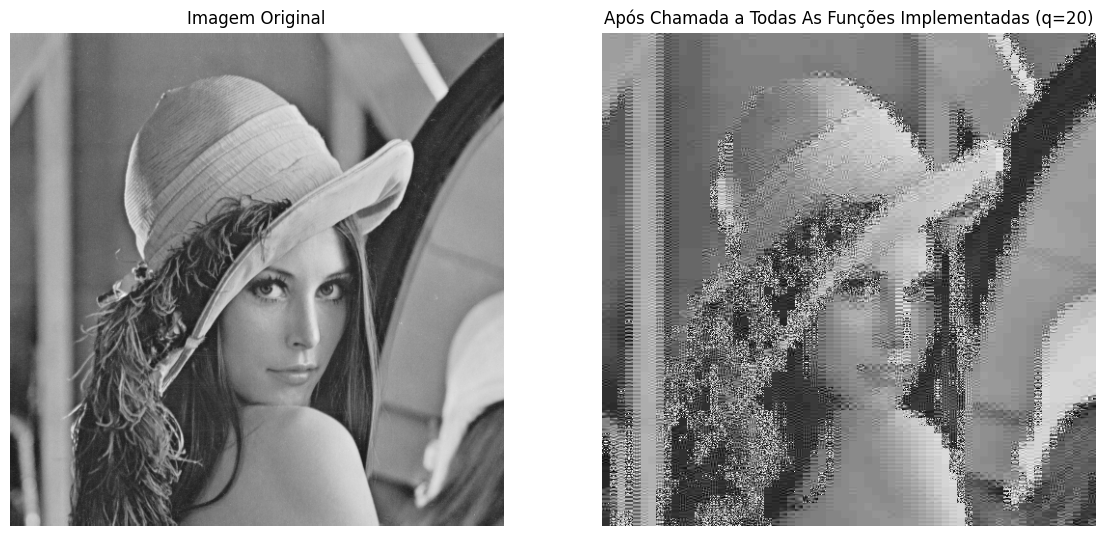

In [1654]:

## Mostrar Imagens no Notebook ##
plt.figure(figsize=(14,14))
plt.subplot(121)
plt.imshow(cv.cvtColor(imagem, cv.COLOR_BGR2RGB))
plt.title('Imagem Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(cv.cvtColor(imagemReconstruida, cv.COLOR_BGR2RGB))
plt.title('Após Chamada a Todas As Funções Implementadas (q=' + str(q) +')')
plt.axis('off')
plt.show()

# Exercício 6
Construa uma função que dados os arrays das alíneas anteriores use as tabelas do código de Huffman (tabela K3
e K5) e grave num ficheiro a sequência de bits correspondente. (não é necessário usar o formato JFIF)


A função recebe dois parâmetros: sequencia e nomeficheiro. A variável sequencia representa a sequência de caracteres que será escrita no ficheiro, e a variável nomeficheiro indica o nome do ficheiro em que a sequência será gravada.

O código utiliza `with open(nomeficheiro, "wb") as f:` para abrir o ficheiro especificado no modo de gravação binária ("wb"). Isso garante que a sequência de caracteres seja gravada exatamente como está, sem qualquer processamento ou modificação adicional.

Dentro do `with`, o ficheiro é referenciado pela variável `f`. Em seguida, a função `write()` é chamada em `f` para gravar a sequência no ficheiro. Antes de escrever, a sequência é convertida para o formato utf-8 usando o método `encode('utf-8')`, que retorna uma sequência de bytes correspondente à codificação UTF-8 da sequência de caracteres.

In [1655]:
def write2file(sequencia, nomeficheiro):
    
    with open(nomeficheiro, "wb") as f:
        f.write(sequencia.encode('utf-8'))

In [1656]:
nome = 'ficheiroTeste'
print(f"A escrever no ficheiro: {nome}")
write2file(imagemCodJPEG, nome)

A escrever no ficheiro: ficheiroTeste


# Exercício 7
Construa uma função que leia o ficheiro gravado e retorne os arrays com os coeficientes AC e DC.


A função `readFile`, que tem como objetivo ler o conteúdo de um ficheiro especificado pelo nome do ficheiro.

A função recebe um parâmetro, nomeficheiro, que indica o nome do ficheiro que será lido.

O código utiliza `with open(nomeficheiro, "rb") as f:` para abrir o ficheiro especificado no modo de leitura binária ("rb"), o que permite a leitura dos dados do ficheiro como bytes, preservando sua representação original.

Dentro do `with`, o ficheiro é referenciado pela variável `f`. Em seguida, a função `read()` é chamada em `f` para ler o conteúdo do ficheiro. O método `frombuffer()` da biblioteca NumPy é utilizado para criar um array NumPy a partir dos bytes lidos. O parâmetro dtype="uint8" indica que os bytes devem ser interpretados como números inteiros sem sinal de 8 bits.

Por fim, a função retorna o array `blk_int` contendo os dados lidos do ficheiro.

In [1657]:
def readFile(nomeficheiro):
    with open(nomeficheiro, "rb") as f:
        informacao = f.read()
        
    informacao = [format(byte, '08b') for byte in informacao]
    informacao = ''.join(informacao)
    
    stuffing_length = int(informacao[:3], 2)
    informacao = informacao[3:len(informacao) - stuffing_length]
    
    q = int(informacao[:7], 2)
    informacao = informacao[7:]
    
    linhas = int(informacao[:11], 2)
    informacao = informacao[11:]
    
    colunas = int(informacao[:11], 2)
    informacao = informacao[11:]
    
    return q, linhas, colunas, informacao

In [1658]:
# Nome do ficheiro a ler
name_file = "ficheiroTeste"
# Leitura do ficheiro
q, linhas, colunas, info = readFile(name_file)
# Prints
print(f"A ler ficheiro: {name_file}")
#print(f"Conteúdo do ficheiro: {info}")

A ler ficheiro: ficheiroTeste


# Exercício 8
Junte estas funções às já realizadas e veja a imagem descodificada.
Para diferentes factores de qualidade meça a relação sinal-ruído e a taxa de compressão obtida. Represente um
gráfico onde se apresente a taxa de compressão em função do SNR.



A função `processar` tem como objetivo adicionar cabeçalhos necessários para reconstruir a imagem ao código da imagem fornecido. Primeiramente, são criados os cabeçalhos necessários: cabeçalho 1 contendo o número de linhas e colunas da imagem, cabeçalho 2 contendo informações extras sobre as linhas e colunas, e cabeçalho 3 contendo a qualidade da imagem. Esses cabeçalhos são formatados como sequências de bits e concatenados ao código da imagem original.

Em seguida, é realizado o bit stuffing para garantir que o comprimento do código seja um múltiplo de 8. Se necessário, são adicionados bits "0" ao final do código para preencher o restante dos bytes. A quantidade de bits redundantes adicionados é registada como um valor de 3 bits no início do código.

Após o bit stuffing, o código é dividido em blocos de 8 bits e convertido para o tipo de dados "uint8" para uma melhor manipulação. Por fim, o resultado final é retornado como uma matriz numpy contendo os blocos de 8 bits.

In [1659]:
# Processa o código da imagem de forma a conter os headers que o recetor necessita para reconstruir a imagem
def processar(codigo, nLinhas, nColunas, lExtra, cExtra, f_qualidade):
    
    # Adicionar header 1
    header_linhas = format(nLinhas, "016b")
    header_colunas = format(nColunas, "016b")
    
    # Adicionar header 2
    header_lExtra = format(lExtra, "03b")
    header_cExtra = format(cExtra, "03b")
    
    # Adicionar header 3
    header_f = format(f_qualidade, "07b")
    
    codigo = header_linhas + header_colunas + header_lExtra + header_cExtra + header_f + codigo # Juntar os headers
    
    # Bit Stuffing
    bit_stuff = 0
    if np.remainder(len(codigo)+3, 8) > 0:
        bit_stuff = 8-np.remainder(len(codigo)+3, 8)
    codigo = codigo + '0'*bit_stuff

    n_bits_redundantes = format(bit_stuff, "03b")
    print("Número de bits redundantes adicionados (em binário): " + n_bits_redundantes)
    codigo = n_bits_redundantes + codigo
    
    # Dividir em blocos de 8 bits
    blk = re.findall('[01]{8}', codigo)
    
    # Converter blocos para "uint8"
    blk_int = np.array([int(c,2) for c in blk], dtype="uint8")
    
    return blk_int

A função `desprocessar` tem como objetivo extrair as informações dos cabeçalhos e o código da imagem a partir do código processado. 

Primeiro, os blocos lidos são convertidos de valores inteiros para a representação binária de 8 bits. Em seguida, esses blocos são concatenados numa única string.

Os primeiros 3 bits (flag) são lidos para determinar a quantidade de bits redundantes adicionados durante o processo de processamento. Se houver bits redundantes, eles são removidos da string de código.

Os cabeçalhos são extraídos da string de código, conforme especificado pelos seus comprimentos. O cabeçalho 4.1 contém o número de linhas e colunas da imagem, o cabeçalho 4.2 contém informações extras sobre as linhas e colunas, e o cabeçalho 4.3 contém a qualidade da imagem.

As informações extraídas são armazenadas num dicionário chamado `info`, que contém os valores dos cabeçalhos e o código da imagem.

Por fim, o dicionário `info` é retornado como resultado da função.

In [1660]:
def desprocessar(codigo):
    # Passar os blocos lidos de inteiro para representação binária
    blk_bin = [format(d, "08b") for d in codigo]
    
    # Juntar tudo numa string
    codigo = ''.join(blk_bin)
    
    # Agora lemos os primeiros 3 bits (flag) para podermos de seguida remover os bits redundantes
    n_bits_a_retirar = int(codigo[:3], 2)
    
    # Remover os bits redudantes
    if n_bits_a_retirar != 0:
        codigo = codigo[3:-n_bits_a_retirar] # Caso fosse 0 aqui daria um problema de indexação
    else:
        codigo = codigo[3:]
        
    # Extrair headers 4.1
    header_linhas = int(codigo[:16], 2)
    codigo = codigo[16:]
    header_colunas = int(codigo[:16], 2)
    codigo = codigo[16:]
    
   # Extrair headers 4.2
    header_lExtra = int(codigo[:3], 2)
    codigo = codigo[3:]
    header_cExtra = int(codigo[:3], 2)
    codigo = codigo[3:]
    
    # Extrair headers 4.3
    header_f = int(codigo[:7], 2)
    codigo = codigo[7:]
    
    info = dict()
    info.update({"nLinhas": header_linhas})
    info.update({"nColunas": header_colunas})
    info.update({"lExtra": header_lExtra})
    info.update({"cExtra": header_cExtra})
    info.update({"f_qualidade": header_f})
    info.update({"codigo": codigo})
    
    return info

A função `taxa_compressao` calcula a taxa de compressão entre um arquivo original e um arquivo comprimido. 

Primeiro, a função utiliza a biblioteca `os` para obter o tamanho dos arquivos original e comprimido usando a função `os.path.getsize()`. Em seguida, é calculada a razão entre os tamanhos, dividindo o tamanho do arquivo original pelo tamanho do arquivo comprimido.

A taxa de compressão resultante, representada pela variável `Ts`, é retornada como resultado da função. Essa taxa indica quantas vezes o arquivo original é menor em relação ao arquivo comprimido.

In [1661]:
def taxa_compressao(original, comprimida):
    Ts = os.path.getsize(original) / os.path.getsize(comprimida)
    return Ts

A função `measure_SNR` calcula a relação sinal-ruído (SNR) entre um sinal original e um sinal comprimido.

Primeiro, os sinais original e comprimido são convertidos para o tipo de dados float para permitir cálculos precisos. Em seguida, é calculado o erro entre os sinais original e comprimido, subtraindo um do outro.

Depois, são calculadas as potências médias dos sinais original e do erro. A potência média do sinal original, representada por `Px`, é calculada como a média dos quadrados dos valores do sinal original. A potência média do erro, representada por `Pe`, é calculada como a média dos quadrados dos valores do erro.

Com base nas potências médias, é calculada a relação SNR em decibéis (dB) usando a fórmula `SNR = 10 * log10(Px/Pe)`. Essa relação indica a relação entre a potência do sinal original e a potência do ruído introduzido durante a compressão.

O valor SNR resultante é retornado como resultado da função. Quanto maior o valor SNR, melhor a qualidade da compressão em termos de fidelidade do sinal original.

In [1662]:
def measure_SNR(original, comprimida):
    e = original.astype(float) - comprimida.astype(float)
    Px = np.mean(original.astype(float)**2)
    Pe = np.mean(e.astype(float)**2)
    SNR = 10 * np.log10(Px/Pe)
    return SNR

In [1663]:
def compressor(imagem, q, nomeFicheiro):
    t0 = time()
    img_divided = divide_imagem_8x8(imagem)
    dct_img = dct_blocos(img_divided)
    quantific_img = codificador_quantize(dct_img, q)
    jpegCode = cod_JPEG(quantific_img)
    # Guarda o tempo que demorou a comprimir
    write2file(jpegCode, nomeFicheiro)
    return round(time() - t0, 2)

def descompressor(nomeFicheiro):
    q, linhas, colunas, info = readFile(nomeFicheiro)
    # Inicio da contagem do tempo descompressao
    t0 = time()
    
    #i_descodific = descodificador_JPEG(info, int((linhas/8) * (colunas/8)))
    i_descodific = descodificador_JPEG(info, linhas * colunas)
    # Realizar a desquantificação
    i_desquantific = descodificador_quantize(i_descodific, q)
    # Realizar a dct inversa
    i_idct = reverter_DCT(i_desquantific)
    # CLip
    i_clipped = np.clip(i_idct, 0, 255).astype(int)
    # Juntar blocos
    i_img = reconstruir_imagem(i_clipped, linhas, colunas)
   
    

    return i_img, round(time()-t0, 3)

In [1664]:
imagem_resized = acertar_tamanho_imagem(imagem)

In [1665]:
codigo_a_escrever = processar(codific, imagem_resized[0].shape[0], imagem_resized[0].shape[1], imagem_resized[1], imagem_resized[2], qualidade)

Número de bits redundantes adicionados (em binário): 001


In [1666]:
dicionario_recebido = desprocessar(codigo_a_escrever)
print(dicionario_recebido["codigo"] == codific)

True


In [1667]:
i_descodificado = descodificador_JPEG(dicionario_recebido["codigo"], int((dicionario_recebido["nLinhas"]/8) * (dicionario_recebido["nColunas"]/8)))
i_descodificado

array([[[ 16,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   1,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[ 15,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   1,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[ 14,   0,   0, ...,   0,  -1,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   1,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[-36,   1,   0, ...,   0,   0,   0],
        [  0,   1,   0, ...,   0,   0,   0],
        [  2,   4,   0, ...,   0,   0,   0

In [1668]:
# Realizar a desquantificação
i_desquantificado = descodificador_quantize(i_descodificado, dicionario_recebido["f_qualidade"])
i_desquantificado

[array([[256.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  13.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([[240.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  13.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [ 36.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]]),
 array([[224.,   0.,   0.,   0.,   0.,   0., -51.,   0.],
        [ 

In [1669]:
# Realizar a dct inversa
i_idct = reverter_DCT(i_desquantificado)
i_idct

array([[[162.94000244, 162.5       , 161.66999817, ..., 158.33000183,
         157.5       , 157.05999756],
        [161.22000122, 161.02999878, 160.69000244, ..., 159.30999756,
         158.97000122, 158.77999878],
        [158.77999878, 158.97000122, 159.30999756, ..., 160.69000244,
         161.02999878, 161.22000122],
        ...,
        [158.77999878, 158.97000122, 159.30999756, ..., 160.69000244,
         161.02999878, 161.22000122],
        [161.22000122, 161.02999878, 160.69000244, ..., 159.30999756,
         158.97000122, 158.77999878],
        [162.94000244, 162.5       , 161.66999817, ..., 158.33000183,
         157.5       , 157.05999756]],

       [[165.44000244, 165.        , 164.16999817, ..., 160.83000183,
         160.        , 159.55999756],
        [154.72000122, 154.52999878, 154.19000244, ..., 152.80999756,
         152.47000122, 152.27999878],
        [152.27999878, 152.47000122, 152.80999756, ..., 154.19000244,
         154.52999878, 154.72000122],
        ...,


In [1670]:
# CLip
i_clipped = np.clip(i_idct, 0, 255).astype(int)
i_clipped

array([[[162, 162, 161, ..., 158, 157, 157],
        [161, 161, 160, ..., 159, 158, 158],
        [158, 158, 159, ..., 160, 161, 161],
        ...,
        [158, 158, 159, ..., 160, 161, 161],
        [161, 161, 160, ..., 159, 158, 158],
        [162, 162, 161, ..., 158, 157, 157]],

       [[165, 165, 164, ..., 160, 160, 159],
        [154, 154, 154, ..., 152, 152, 152],
        [152, 152, 152, ..., 154, 154, 154],
        ...,
        [152, 152, 152, ..., 154, 154, 154],
        [154, 154, 154, ..., 152, 152, 152],
        [165, 165, 164, ..., 160, 160, 159]],

       [[157, 169, 151, ..., 148, 164, 151],
        [151, 163, 146, ..., 144, 161, 149],
        [149, 161, 144, ..., 146, 163, 151],
        ...,
        [149, 161, 144, ..., 146, 163, 151],
        [151, 163, 146, ..., 144, 161, 149],
        [157, 169, 151, ..., 148, 164, 151]],

       ...,

       [[ 95,  88,  78, ...,  59,  60,  62],
        [ 43,  49,  57, ...,  46,  33,  24],
        [ 44,  42,  41, ...,  42,  45,  46

In [1671]:
# Juntar blocos
i_imagem = reconstruir_imagem(i_clipped, dicionario_recebido["nLinhas"], dicionario_recebido["nColunas"])
i_imagem

array([[162., 162., 161., ..., 167.,  18.,  59.],
       [161., 161., 160., ..., 110., 118., 251.],
       [158., 158., 159., ..., 172., 113., 169.],
       ...,
       [ 53.,  52.,  50., ..., 100., 104., 106.],
       [ 41.,  48.,  58., ..., 119., 103.,  90.],
       [ 57.,  53.,  46., ...,  76.,  93., 104.]])

In [1672]:
# Retornar ao tamanho original da imagem
i_descomprimida = revert_imagem(i_imagem, dicionario_recebido["lExtra"], dicionario_recebido["cExtra"]).astype("uint8")
i_descomprimida

array([[162, 162, 161, ..., 167,  18,  59],
       [161, 161, 160, ..., 110, 118, 251],
       [158, 158, 159, ..., 172, 113, 169],
       ...,
       [ 53,  52,  50, ..., 100, 104, 106],
       [ 41,  48,  58, ..., 119, 103,  90],
       [ 57,  53,  46, ...,  76,  93, 104]], dtype=uint8)

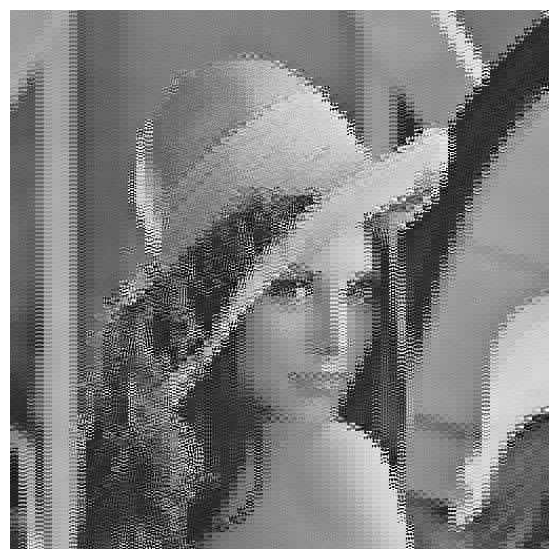

In [1673]:
plt.figure(figsize=(7, 7))
plt.imshow(cv.cvtColor(i_descomprimida, cv.COLOR_BGR2RGB)) # Como o openCV trabalha no canal BGR e o matplotlib com o RGB, 
plt.axis("off");  

# Exercício 9
No mesmo gráfico compare o seu compressor de imagem com outros existentes para várias qualidades.


Text(0.5, 1.0, 'Imagem Comprimida - OpenCV')

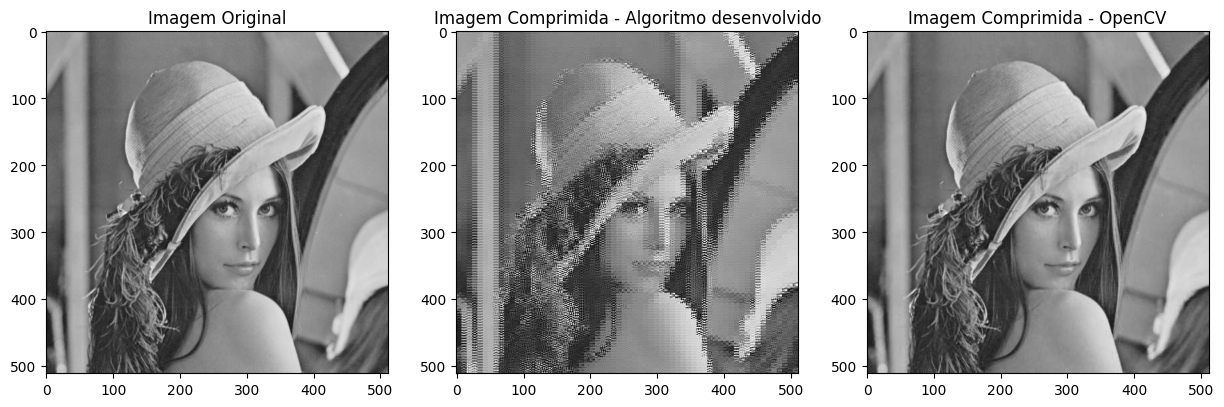

In [1676]:
# Obter outros compressores JPEG
img_OpenCV = imagem
cv.imwrite('JPEG_openCV.jpg', img_OpenCV, (cv.IMWRITE_JPEG_QUALITY,qualidade))
img_OpenCV = cv.imread("JPEG_openCV.jpg")

# Comparar imagem original com as várias comprimidas
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 15))
ax1.imshow(cv.cvtColor(imagem, cv.COLOR_BGR2RGB))
ax1.set_title("Imagem Original")
ax2.imshow(cv.cvtColor(i_descomprimida, cv.COLOR_BGR2RGB))
ax2.set_title("Imagem Comprimida - Algoritmo desenvolvido")
ax3.imshow(cv.cvtColor(img_OpenCV, cv.COLOR_BGR2RGB))
ax3.set_title("Imagem Comprimida - OpenCV")

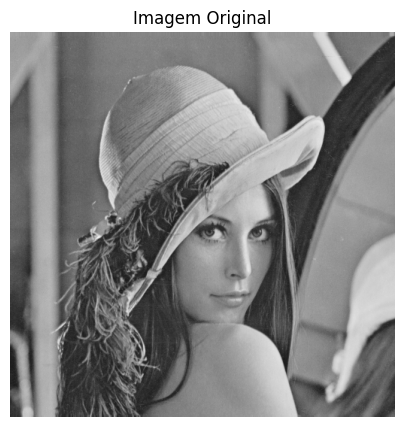

   Tamanho do Ficheiro Original: 210122 bits


«------------ Teste ao ficheiro: LenaGrayTestJPEG5 » ------------»
Taxa de Compressão:3.512

SNR:11.15452 dBs
Tempo de Compressão:0.22s

«------------ Teste ao ficheiro: LenaGrayTestJPEG20 » ------------»
Taxa de Compressão:1.457

SNR:11.15452 dBs
Tempo de Compressão:0.32s

«------------ Teste ao ficheiro: LenaGrayTestJPEG35 » ------------»
Taxa de Compressão:1.04

SNR:11.15452 dBs
Tempo de Compressão:0.49s

«------------ Teste ao ficheiro: LenaGrayTestJPEG50 » ------------»
Taxa de Compressão:0.845

SNR:11.15452 dBs
Tempo de Compressão:0.48s

«------------ Teste ao ficheiro: LenaGrayTestJPEG65 » ------------»
Taxa de Compressão:0.693

SNR:11.15452 dBs
Tempo de Compressão:0.61s

«------------ Teste ao ficheiro: LenaGrayTestJPEG80 » ------------»
Taxa de Compressão:0.515

SNR:11.15452 dBs
Tempo de Compressão:0.81s

«------------ Teste ao ficheiro: LenaGrayTestJPEG95 » ------------»
Taxa de Compressão:0.265

SNR:11.15452 dBs
Tempo de Compres

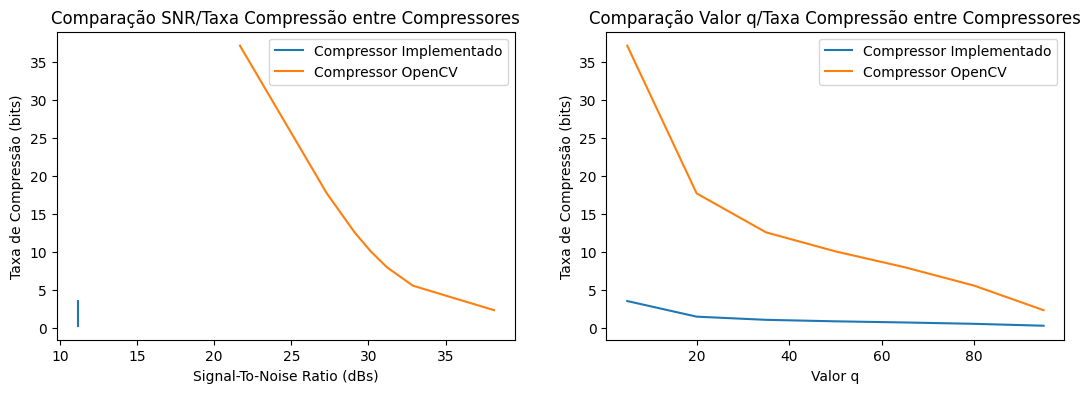

In [1677]:
lenaGrayTeste = np.array(cv.imread("LenaGray.tif", flags=cv.IMREAD_GRAYSCALE), dtype="uint8")

plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(imagem, cv.COLOR_BGR2RGB))
plt.title('Imagem Original')
plt.axis('off')
plt.show()
print('   Tamanho do Ficheiro Original: ' + str(path.getsize("LenaGray.tif")) + ' bits')

temposCompressaoLena    = []
temposDescompressaoLena = []
taxasCompressaoLena     = []
SNRLena                 = []

SNRLenaOpenCV   = []
taxasLenaOpenCV = []

print()
# Valores de q que serão enviados
valoresQ = np.arange(5, 100, 15)
for valorQ in valoresQ:
    
    # Usa-se o compressor JPEG da biblioteca OpenCV no âmbito de comparação de resultados
    cv.imwrite('testeJPEGLenaOpenCV' + str(valorQ) + '.jpg', lenaGrayTeste, (cv.IMWRITE_JPEG_QUALITY, valorQ))
    

    nomeTeste = "LenaGrayTesteJPEG" + str(valorQ)
    tempoCompressao  =  (compressor(lenaGrayTeste, valorQ, nomeTeste))

    #i_descomprimida, tempoDescompressao = descompressor(nomeTeste)
    # Cálculo da SNR e Taxa de Compressão
    snr            =  measure_SNR(lenaGrayTeste, i_descomprimida)
    taxaCompressao = round(1.* path.getsize("LenaGray.tif") / path.getsize(nomeTeste), 3)
    
    temposCompressaoLena.append(tempoCompressao)
    #temposDescompressaoLena.append(tempoDescompressao)
    taxasCompressaoLena.append(taxaCompressao)
    SNRLena.append(snr)


    # Realizar o mesmo para a SNR e Taxa de Compressão resultantes do uso do compressor da biblioteca OpenCV
    SNRLenaOpenCV.append(measure_SNR(lenaGrayTeste, np.array(cv.imread('testeJPEGLenaOpenCV' + str(valorQ) + '.jpg', flags=cv.IMREAD_GRAYSCALE), dtype="uint8")))
    taxasLenaOpenCV.append(round(1.* path.getsize("LenaGray.tif") / path.getsize('testeJPEGLenaOpenCV' + str(valorQ) + '.jpg'), 3))        

    print(f"\n«------------ Teste ao ficheiro: LenaGrayTestJPEG{valorQ} » ------------»")
    print('Taxa de Compressão:' + str(taxaCompressao))
    print('\nSNR:' + str(round(snr,5)) + ' dBs')
    print('Tempo de Compressão:' + str(tempoCompressao) + 's')   


plt.figure(figsize=(13,4))
plt.subplot(121)
plt.plot(SNRLena, taxasCompressaoLena,  label='Compressor Implementado')
plt.plot(SNRLenaOpenCV, taxasLenaOpenCV, label='Compressor OpenCV')
plt.title('Comparação SNR/Taxa Compressão entre Compressores')
plt.xlabel('Signal-To-Noise Ratio (dBs)')
plt.ylabel('Taxa de Compressão (bits)')
plt.legend(loc='upper right')

# Gráfico que mostra a relação entre o Valor q usado e a Taxa de Compressão, 
# para ambos os compressores usados.
plt.subplot(122)
plt.plot(valoresQ, taxasCompressaoLena, label='Compressor Implementado')
plt.plot(valoresQ, taxasLenaOpenCV, label='Compressor OpenCV')
plt.title('Comparação Valor q/Taxa Compressão entre Compressores')
plt.ylabel('Taxa de Compressão (bits)')
plt.xlabel('Valor q')
plt.legend(loc='upper right')
plt.show()
fig.tight_layout()
plt.show()

# Exercício 10
O Jupyter Notebook o deve conter uma descrição breve das funções realizadas e uma tabela com todos os
resultados da SNR, taxa de compressão, tempo de compressão e descompressão.


# Conclusões
...